In [1]:
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from collections import defaultdict

In [2]:
class ReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        mask = x > 0
        ctx.save_for_backward(mask)
        return x * mask

    @staticmethod
    def backward(ctx, grad_output):
        mask, = ctx.saved_tensors
        return grad_output * mask
    
"""
GELU(x) = x * CDF(x)
CDF(x) = 0.5 * (1.0 + erf(x / sqrt(2.0)))
GELU'(x) = CDF(x) + x * CDF'(x) 
         = CDF(x) + x * PDF(x)
"""

class GELU(torch.autograd.Function):        
    @staticmethod
    def forward(ctx, x):
        cdf = 0.5 * (1.0 + torch.erf(x / 2.0 ** 0.5)) 
        ctx.save_for_backward(x, cdf)
        return x * cdf

    @staticmethod
    def backward(ctx, grad_output):
        x, cdf = ctx.saved_tensors
        pdf = torch.distributions.Normal(0, 1).log_prob(x).exp()
        return grad_output * (cdf + x * pdf)
    
"""
Swish(x) = x * S(x) 
Swish'(x) = (x * S(x))' 
          = x' * S(x) + x * S'(x)
          = S(x) + x * S(x) * (1 - S(x)) * x'
          = S(x) + Swish(x) * (1 - S(x))
"""
    
class Swish(torch.autograd.Function):        
    @staticmethod
    def forward(ctx, x):
        sigmoid = torch.sigmoid(x)
        swish = x * sigmoid
        ctx.save_for_backward(swish, sigmoid)
        return swish

    @staticmethod
    def backward(ctx, grad_output):
        swish, sigmoid = ctx.saved_tensors
        derivative = sigmoid + swish * (1 - sigmoid)
        return grad_output * derivative

"""
Softplus(x) = ln(1 + e^x) 

Softplus'(x) = 1/(1 + e^x) * e^x
             = e^x/(1 + e^x)
             = 1/(1 + e^(-x))
"""
    
class Softplus(torch.autograd.Function):        
    @staticmethod
    def forward(ctx, x):
        softplus = torch.log(1 + torch.exp(x))
        ctx.save_for_backward(x)
        return softplus

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        derivative = 1/(1 + torch.exp(-x))
        return grad_output * derivative

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 9877758.44it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 190381.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3544513.21it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10568907.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size,
                              worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             worker_init_fn=seed_worker, generator=g)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.activation = activation 
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

Using cuda device


In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


epochs = 20

activations = ['ReLU', 'GELU', 'Swish', 'Softplus']
activation2class = {
    'ReLU': ReLU.apply,
    'GELU': GELU.apply,
    'Swish': Swish.apply,
    'Softplus': Softplus.apply,
}
accs = defaultdict(list)

for a in activations:
    print(a)
    
    model = NeuralNetwork(activation2class[a]).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    
    for t in tqdm(range(epochs)):
        # print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        acc = test(test_dataloader, model, loss_fn)
        accs[a].append(acc)

ReLU


100%|██████████| 20/20 [02:56<00:00,  8.81s/it]


GELU


100%|██████████| 20/20 [03:15<00:00,  9.75s/it]


Swish


100%|██████████| 20/20 [03:00<00:00,  9.01s/it]


Softplus


100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


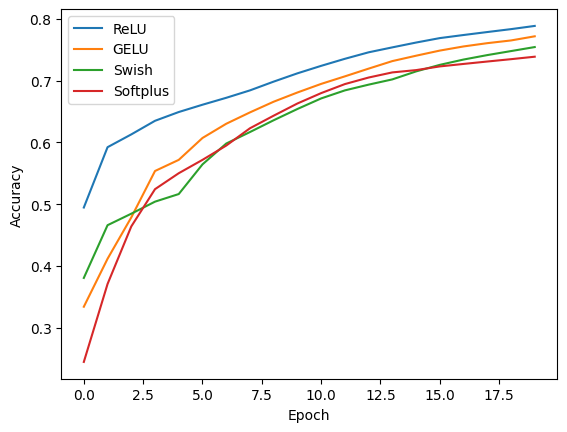

In [15]:
for k, v in accs.items():
    plt.plot(v, label=k)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()